#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ данных</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение моделей</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li></ul></div>

## Подготовка

In [1]:
import pandas as pd
import datetime as dt
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from catboost import CatBoostRegressor
from sklearn.pipeline import Pipeline

In [2]:
data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [3]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [4]:
# Визульано вижу,что временной ряд расположен в хронологическом порядке, но на всякий случай проверим
data.index.is_monotonic

True

In [5]:
data.index.min(), data.index.max()

(Timestamp('2018-03-01 00:00:00'), Timestamp('2018-08-31 23:50:00'))

Данные представлены как упорядоченный временной ряд с 1 марта 2018 года по 31 августа 2018 года. Количество заказов такси распределено за каждые 10 минут

## Анализ

In [6]:
#Ресемплируем данные по одному часу, неделе и месяцу
hourly_stat = data.resample('1H').sum()
monthly_stat= data.resample('1M').sum()
weekly_stat = data.resample('1W').sum()

Text(0.5, 1.0, 'Количество заказов в месяц')

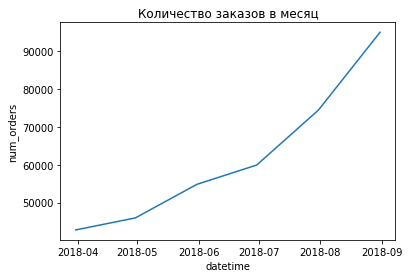

In [7]:
#Посмотрим на статистику заказов в разбивке по месяцам
sns.lineplot(x=monthly_stat.index,y=monthly_stat['num_orders']).set_title('Количество заказов в месяц')

Text(0.5, 1.0, 'Количество заказов в неделю')

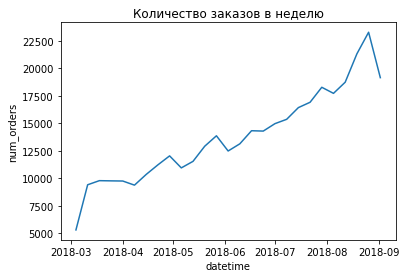

In [8]:
#Посмотрим на статистику заказов в разбивке по неделям
sns.lineplot(x=weekly_stat.index,y=weekly_stat['num_orders']).set_title('Количество заказов в неделю')

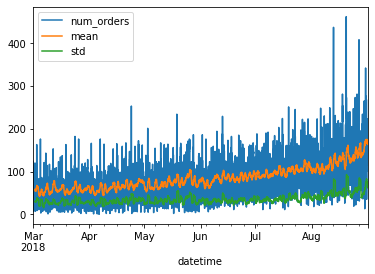

In [9]:
#Посмотрим на скользящее среднее и скользящее стандартное отклонение по часам
hourly_stat['mean'] = hourly_stat['num_orders'].rolling(25).mean()
hourly_stat['std'] = hourly_stat['num_orders'].rolling(25).std()
hourly_stat.plot();

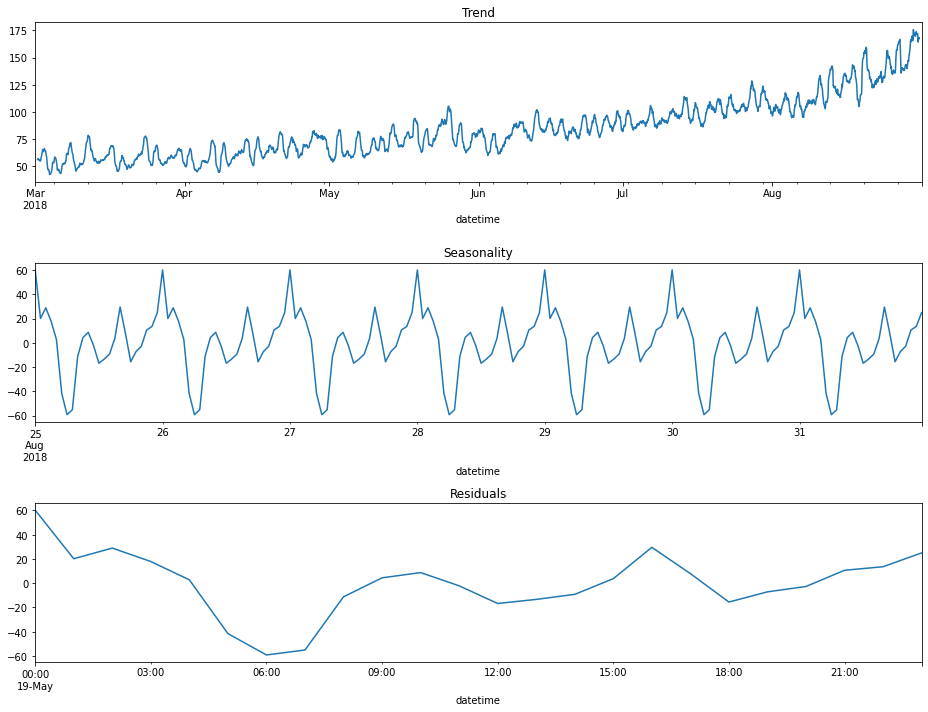

In [10]:
#Построим график сезонной составляющей
decomposed = seasonal_decompose(data.resample('1H').sum()) 

plt.figure(figsize=(13, 10))
plt.subplot(311)

decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.tail(24*7).plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.seasonal['2018-05-19':'2018-05-19'].plot(ax=plt.gca()) 
plt.title('Residuals')
plt.tight_layout()

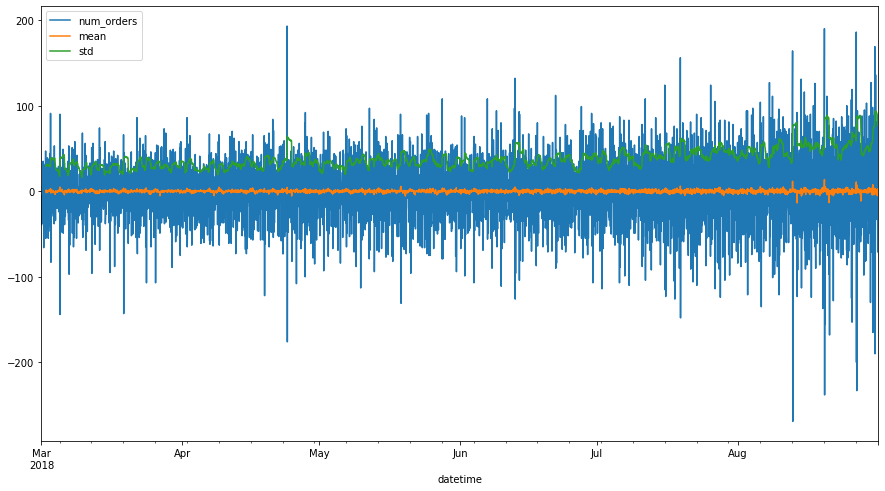

In [11]:
#Разности временного ряда
data = data.resample('1H').sum()
data_shift = data - data.shift()
data_shift['mean'] = data_shift['num_orders'].rolling(24).mean()
data_shift['std'] = data_shift['num_orders'].rolling(24).std()
data_shift.plot(figsize=(15,8));

Проанализировав данные, можно сделать вывод, что количество заказов непрерывно увеличивалось, это наблюдается как в ежемесячном, так и в еженедельном графиках. Общий тренд на количество заказов растет. Повторяемость данных четко видна в спросе по часам. Чаще заказывают такси  в ночное время (около 12 ночи), перед началом рабочего дня (8-11 утра), по окончании рабочего дня (16-17 ч.)

## Обучение

In [12]:
#Функция создания признаков для модели
def make_features(data, max_lag, rolling_mean_size):
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

In [13]:
make_features(data, 1, 1)
data = data.dropna().reset_index(drop=True)

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4415 entries, 0 to 4414
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   num_orders    4415 non-null   int64  
 1   month         4415 non-null   int64  
 2   day           4415 non-null   int64  
 3   hour          4415 non-null   int64  
 4   lag_1         4415 non-null   float64
 5   rolling_mean  4415 non-null   float64
dtypes: float64(2), int64(4)
memory usage: 207.1 KB


In [15]:
train, test = train_test_split(data, shuffle=False, test_size=0.1)

In [16]:
#Определим признаки и целевой признак у обучающей и тестовой выборк
features_train  = train.drop('num_orders', axis=1)
target_train = train[['num_orders']]
features_test = test.drop('num_orders', axis=1)
target_test = test[['num_orders']]
print(features_train.shape, features_test.shape)
print(target_train.shape, target_test.shape)

(3973, 5) (442, 5)
(3973, 1) (442, 1)


In [17]:
#Построим модель линейной регрессии
model = LinearRegression()

model_lr = model.fit(features_train, target_train) 
predictions_train = model_lr.predict(features_train) # получим предсказания модели
rmse_lr_train = mean_squared_error(target_train, predictions_train,  squared=False)


print("RMSE LinearRegression:", rmse_lr_train)

RMSE LinearRegression: 30.698869206537353


In [18]:
best_model_cbr = None
best_rmse_cbr = 48
learning_rate_range = [0.01, 0.05]

for iteration in range(150, 250, 25):
    for learning_rate in learning_rate_range:
        model_cbr =CatBoostRegressor(random_state = 19191,
                                     loss_function="RMSE", 
                                     iterations=iteration, 
                                     learning_rate=learning_rate, 
                                     verbose=False) 

        model_cbr.fit(features_train, 
                      target_train)

        predicted_train = model_cbr.predict(features_train)
        rmse_cbr = mean_squared_error(target_train, predicted_train, squared=False)
    if rmse_cbr < best_rmse_cbr:
        best_model_cbr = model_cbr
        best_rmse_cbr = rmse_cbr


print("CatBoostRegressor")
print(f"Model params: {best_model_cbr.get_params()}")
print("RMSE =", best_rmse_cbr)

CatBoostRegressor
Model params: {'iterations': 225, 'learning_rate': 0.05, 'loss_function': 'RMSE', 'verbose': False, 'random_state': 19191}
RMSE = 21.230510508749855


In [19]:
best_model_RFC = None
best_rmse_RFC = 48
best_est_RFC = 0
best_depth_RFC = 0
for est in range(70, 100, 10):
    for depth in range(1, 5):
        model_RFC = RandomForestRegressor(random_state=19191, n_estimators=est, max_depth=depth)
        model_RFC.fit(features_train, target_train.values.ravel())

        predicted_train = model_RFC.predict(features_train)
        rmse_RFC = mean_squared_error(target_train, predicted_train, squared=False)
    if rmse_RFC < best_rmse_RFC:
        best_model_RFC = model_RFC
        best_rmse_RFC = rmse_RFC
        best_est_RFC = est
        best_depth_RFC = depth
print("RMSE наилучшей модели RandomForest:", best_rmse_RFC, "Количество деревьев:", best_est_RFC, 'Глубина:', best_depth_RFC)

RMSE наилучшей модели RandomForest: 25.926776591930974 Количество деревьев: 80 Глубина: 4


Я сравнила Линейную регрессию, CatBoost и RandomForestRegressor. RMSE модели CatBoostRegressor ниже показателей линейной регрессии и RandomForest. 
Проверим CatBoostRegressor на тестовой выборке

## Тестирование

In [20]:
predictions_test_cbr = best_model_cbr.predict(features_test) # получим предсказания модели
rmse_cbr_test = mean_squared_error (target_test, predictions_test_cbr,  squared=False)
print("RMSE тестовой выборки CatBoostRegressor: ", rmse_cbr_test)

RMSE тестовой выборки CatBoostRegressor:  46.480947937820424


**Итоговый вывод:**

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Данные представлены как упорядоченный временной ряд с 1 марта 2018 года по 31 августа 2018 года. Количество заказов такси распределено за каждые 10 минут.

Проанализировав данные, можно сделать вывод, что в течение всего времени количество заказов непрерывно увеличивалось, это наблюдается как в ежемесячном, так и в еженедельном графиках. Общий тренд на количество заказов растет. Повторяемость данных четко видна в спросе по часам. Чаще заказывают такси  в ночное время (около 12 ночи), перед началом рабочего дня (8-11 утра), по окончании рабочего дня (16-17 ч.)

Для того, чтобы привлекать больше водителей в период пиковой нагрузки, было спрогнозировано количество заказов такси на следующий час. Линейная регрессия показала RMSE хуже CatBoost. RMSE тестовой выборки CatBoostRegressor:  46.8, что соотвествует целевому значения заказчика (<48).